# Tutorial 4: Computed Tomography

Continuing our exposition on the applications of Fourier transform, today we are going to understand computed tomography (CT). This is an imaging method that enabled several imaging applications, e.g. X-ray CT scanning.

Agenda:
- Radon transform
- Sinogram
- Back-projection (BP)
- Drawbacks of doing BP
- Slice-projection theorem
- Filtered back-projection
- Practical considerations: doing CT using convolution
- How is the reconstruction done today? patch-based priors, CNNs
- Today's CT scanners: fan-beam CT, cone-beam CT, spectral CT
- Hough transform
 detecting circles or lines in an image

In [1]:
import matplotlib.pyplot as plt
import cv2
import skimage.transform
import numpy as np

## Physics of X-ray CT

Let $f\left(x,y\right)$ be our 2D object of interest that we desire to scan using our X-ray CT machine. 

According to Beer-Lambert's law of light attenuation, the measured intensity of light is given by

$$
I_l=I_0\exp\left(-\int_{l}f\left(x,y\right)\right),
$$

where $I_0$ is the emitted light intensity and $l$ is the infinite line along the ray's direction. Taking the logarithm yields

$$
p_l=-\log\frac{I_l}{I_0}=\int_lf\left(x,y\right).
$$

Our goal is to recover $f\left(x,y\right)$ from $p_l$ for all emmited rays $l$.

<video controls src="ct-at-max-speed.mp4" />


## Parameterization

Since our rays are straight lines, we would like some way to parameterize all possible lines. The problem with a Cartesian coordiante system is that it is unable to handle vertical lines with an infinite slope (and we certainly do not want to exclude all vertical lines from our CT scan).

A line $l$ can be represented by the equation $ax+by=c$ where $a,b,c\in\mathbb{R}$ and $a^2+b^2\neq0$. Thus we can rewrite the standard equation of a line in the following way
$$\frac{a}{\sqrt{a^2+b^2}}x+\frac{b}{\sqrt{a^2+b^2}}y=\frac{c}{\sqrt{a^2+b^2}}.$$
Since $\left(\frac{a}{\sqrt{a^2+b^2}}\right)^2+\left(\frac{b}{\sqrt{a^2+b^2}}\right)^2=1$, we can also write
$$x\cos\theta+y\sin\theta=\frac{c}{\sqrt{a^2+b^2}}$$
for a fixed $0\leq\theta\leq\pi$. Lastly, we will denote $s=\frac{c}{\sqrt{a^2+b^2}}$ and get
$$x\cos\theta+y\sin\theta=s.$$

The parameterization $\left(\theta,s\right)$ identifies with the blue line in the following figure.

<img src="line.png" width="360">

Thus for a line $l$ parameterized as $\left(\theta,s\right)$, we will write
$$p_l=p_\theta\left(s\right)=-\text{log}\frac{I_\left(\theta,s\right)}{I_0}=\int_{l_{\left(\theta,s\right)}}f\left(x,y\right).$$

## Radon transform

We desire to scan our object of interest using a parallel beam of X-rays.

<img src="object-scan.png" width="360">

In the above shown scan, each $\theta$ represents a line that emitts/absorbs parallel rays simultaneously. Each ray originates from one of the points on the line indicated by the different values of $s$. What we obtain at the other end is called the _absorption profile_ of the tissue. Here, since our body is pixelized, the absorption profile is nothing but the sum of the pixels along a specific ray. In the continous case, it is the line integral along that ray:

$$
g\left(\theta,s\right)=p_\theta\left(s\right)=\iint_{\mathbb{R}^2}f\left(x,y\right)\delta\left(xcos(\theta)+ysin(\theta)-s=0\right)dxdy.
$$

This is called the *Radon transform*.

## Sinograms

The image obtain from the Radon transform is called a *sinogram*.

Let's present a few singorams. First we'll create a phantom that we would like to scan.

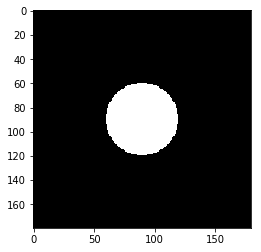

In [2]:
A = -90
B = 90
NUM_SAMPLES = 180
X0 = Y0 = 0
R = 30

axis = np.linspace(A, B, num=NUM_SAMPLES)
x, y = np.meshgrid(axis, axis)
r = np.sqrt((x - X0) ** 2 + (y - Y0) **  2)
inside = r < R

circle = np.zeros((NUM_SAMPLES, NUM_SAMPLES))
circle[inside] = 1
plt.imshow(circle, cmap='gray')
plt.show()

We'll create another more complicated phantom for comparison.

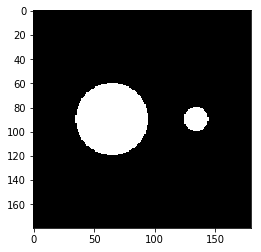

In [3]:
A = -90
B = 90
NUM_SAMPLES = 180
X1 , Y1, R1 = -25, 0, 30
X2, Y2, R2 = 45, 0, 10

axis = np.linspace(A, B, num=NUM_SAMPLES)
x, y = np.meshgrid(axis, axis)
r1 = np.sqrt((x - X1) ** 2 + (y - Y1) **  2)
r2 = np.sqrt((x - X2) ** 2 + (y - Y2) **  2)
inside1 = r1 < R1
inside2 = r2 < R2

two_circles = np.zeros((NUM_SAMPLES, NUM_SAMPLES))
two_circles[inside1] = 1
two_circles[inside2] = 1
plt.imshow(two_circles, cmap='gray')
plt.show()

Let's implement the Radon transform.

In [4]:
def absorption_profile(image, angle):
    rotated = skimage.transform.rotate(image, angle)
    return sum(rotated)

def radon_transform(image, num_angles):
    radon = np.zeros((image.shape[0], num_angles))
    for i in range(num_angles):
        radon[:, i] = absorption_profile(image, -i * 180 / num_angles)
        
    return radon

Let's take a look at the absorption profiles. Try playing with `ANGLE`.

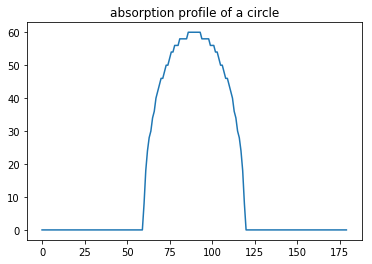

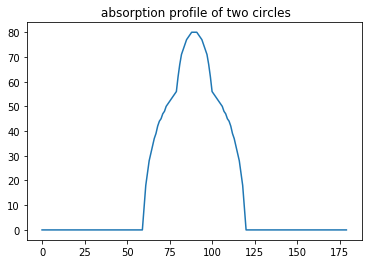

In [5]:
ANGLE = 90

plt.plot(absorption_profile(circle, ANGLE))
plt.title('absorption profile of a circle')
plt.show()

plt.plot(absorption_profile(two_circles, ANGLE))
plt.title(' absorption profile of two circles')
plt.show()

Now let's look at the sinograms. Try playing with the `num_angles` parameter passed to `radon_transform`.

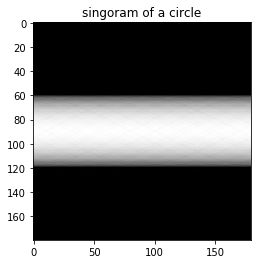

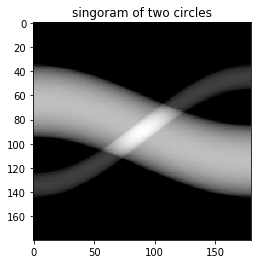

In [6]:
rt_circle = radon_transform(circle, circle.shape[0])
plt.imshow(rt_circle, cmap='gray')
plt.title('singoram of a circle')
plt.show()

rt_two_circles = radon_transform(two_circles, two_circles.shape[0])
plt.imshow(rt_two_circles, cmap='gray')
plt.title('singoram of two circles')
plt.show()

## Back-Projection

Say we have a sinogram with the values of $g\left(\theta,s\right)$ for a fixed angle $\theta$. The trivial way to reconstruct $f\left(x,y\right)$ is to copy each value $g(\theta,s)$ to the line it was obtained from:

$$
b_\theta\left(x,y\right)=g\left(\theta,s\right)\mid_{s=x\cos(\theta)+y\sin(\theta)}=g\left(\theta,x\cos(\theta)+y\sin(\theta)\right)
$$

If we have a sinogram sampled using all angles $0\leq\theta\leq\pi$, we can take the sum:

$$
b\left(x,y\right)=\int_{0}^{\pi}b_\theta\left(x,y\right)d\theta
$$

This algorithm is called *back-projection* and the restoed image is called a *laminogram*.

<img src="back-projection-intuition.png" width="360">

Let's look at the laminograms of the phantoms we have created before. For that we will use the functions `radon` and `iradon` implemented in `skimage.transform`. Try playing with the constant `NUM_ANGLES`.

/Users/omerd/miniconda3/envs/cs236860-tutorials/lib/python3.7/site-packages/skimage/transform/radon_transform.py:58: UserWarning: The default of `circle` in `skimage.transform.radon` will change to `True` in version 0.15.
  warn('The default of `circle` in `skimage.transform.radon` '


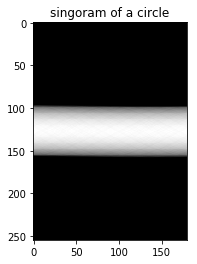

/Users/omerd/miniconda3/envs/cs236860-tutorials/lib/python3.7/site-packages/skimage/transform/radon_transform.py:204: UserWarning: The default of `circle` in `skimage.transform.iradon` will change to `True` in version 0.15.
  warn('The default of `circle` in `skimage.transform.iradon` '


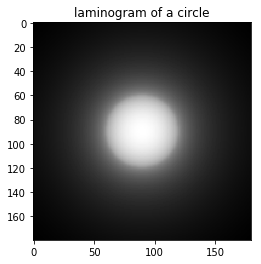

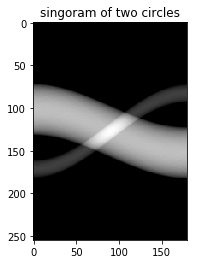

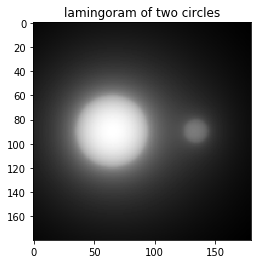

In [7]:
NUM_ANGLES = 180

angles = np.linspace(start=0, stop=179, num=NUM_ANGLES)

singoram_circle = skimage.transform.radon(circle, angles)
plt.imshow(singoram_circle, cmap='gray')
plt.title('singoram of a circle')
plt.show()

laminogram_circle = skimage.transform.iradon(singoram_circle, angles, filter=None)
plt.imshow(laminogram_circle, cmap='gray')
plt.title('laminogram of a circle')
plt.show()

sinogram_two_circles = skimage.transform.radon(two_circles, angles)
plt.imshow(sinogram_two_circles, cmap='gray')
plt.title('singoram of two circles')
plt.show()

laminogram_two_circles = skimage.transform.iradon(sinogram_two_circles, angles, filter=None)
plt.imshow(laminogram_two_circles, cmap='gray')
plt.title('lamingoram of two circles')
plt.show()

Although our lamingorams are similar to the original images, we can notice that the borders are smeared and that the content of the tissue leaks out of the borders. How do we fix this? 

In order to get to this, let us first understand the Slice-Projection theorem.

## Slice-Projection Theorem

Let us consider the 1D Fourier transform of the projection $p_\theta (s)$, we will call it ${P}\left(\theta,\xi\right)$.

We know that
$$
P\left(\theta,\xi\right)=\int_\mathbb{R}p_\theta\left(s\right)e^{-2\pi i\xi s}ds.
$$
If we substitute the value of $p_\theta (s)$ with its formula, we get the following
$$
P\left(\theta,\xi\right)=\int_\mathbb{R}\left(\iint_{\mathbb{R}^2}f\left(x,y\right)\delta\left(xcos(\theta)+ysin(\theta)-s=0\right)dxdy\right)e^{-2\pi i\xi s}ds.
$$
By rearranging the integrals we get
$$
P\left(\theta,\xi\right)=\iint_{\mathbb{R}^2}\left(\int_\mathbb{R}\delta\left(x\cos(\theta)+y\sin(\theta)-s=0\right)e^{-2\pi i\xi s}ds\right)f\left(x,y\right)dxdy.
$$
If we consider the inner integral, the delta function shoots only when $x\cos\theta+y\sin\theta=s$. So upon just substituting the value of $s$, we get
$$
P\left(\theta,\xi\right)=\iint_{\mathbb{R}^2}f\left(x,y\right)e^{-2\pi i\xi\left(x\cos\theta+y\sin\theta\right)} dx dy
=\left.\iint_{\mathbb{R}^2}f\left(x,y\right)e^{-2\pi i\left(xu+yv\right)}\right\Vert_{u=\xi\cos\theta,v=\xi\sin\theta}dxdy,
$$
which finally results in the following Slice-Projection theorem
$$
P\left(\theta,\xi\right)=F\left(\xi\cos\theta,\xi\sin\theta\right)=F_{\text{polar}}\left(\theta,\xi\right).
$$

In effect, we can get the complete Fourier transform $F_{\text{polar}}(\theta,\xi)$ of the unknown function $f$ in polar coordinates $\left(\theta,\xi\right)$, by collecting the 1D projections (and thereby, their Fourier transforms) from all the possible $\theta$'s.


<img src="slice-projection.png" width="640">


## Filtered Back-Projection


The Fourier transform of the desired object $f\left(x,y\right)$ can be written as 

$$
f\left(x,y\right)=\iint_{\mathbb{R}^2}F\left(u,v\right)e^{-2 \pi i\left(ux+vy\right)}dudv.
$$

Since we would like the Fourier transform to be parameterized in $\left(\theta,\xi\right)$, i.e. $u=\xi\cos\theta$ and $v=\xi\sin\theta$, we need to change the integration variables: 


\begin{aligned}
du &= cos\theta d\xi  - \xi sin\theta d\theta\\
dv &= sin\theta d\xi  + \xi cos\theta d\theta
\end{aligned}

$$
\begin{bmatrix}
    du \\
    dv
\end{bmatrix}
= \begin{bmatrix}
    cos \theta & -\xi sin \theta \\
    sin \theta &  \xi cos \theta
\end{bmatrix}
\begin{bmatrix}
    d\xi \\
    d\theta
\end{bmatrix}
$$

Consider the area element with which we integrate the $xy$ space, i.e. $dxdy$. In order to preserve those elements when using the $d\theta d\xi$ elements, we must scale it by the determinant of the matrix above, i.e. by $\left|\xi\right|$.
By this, we obtain:

$$
f\left(x,y\right)=\int_{0}^{\pi}\int_{-\infty}^{\infty}F_{\text{polar}}\left(\theta,\xi\right)\left|\xi\right|e^{-2\pi i\xi\left(x\cos\theta+y\sin\theta\right)}d\xi d\theta.
$$

What does the above equation say? Basically it asks us to calculate the Fourier transform of each projection and multiply it by the filter $H\left(\xi\right)=\left|\xi\right|$. So we can simply write the above equation in the spatial domain as
$$
f\left(x,y\right)
=\int_{0}^{\pi}\left(\int_{-\infty}^{\infty}P\left(\theta,\xi\right)\left|\xi\right|e^{-2\pi i\xi  s}d\xi\right)\vert_{s=x\cos\theta+y\sin\theta}d\theta
=\int_{0}^{\pi}\left.p_\theta\left(s\right)\ast h\left(s\right)\right\vert_{s=x\cos\theta+y\sin\theta}d\theta,
$$
where the first and second equalities are due to the slice-projection and convolution theorems respectively.

In practice we use band-limited approximations of $\left|\xi\right|$:

<img src="freq-spatial-filters.png" width="640">

This method is called *filtered back-projection*. Let's try it and see how it affects the reconstructed image.

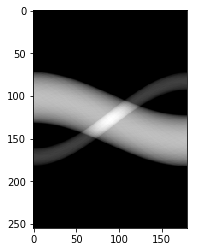

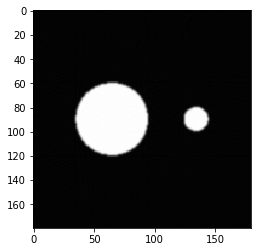

In [8]:
NUM_ANGLES = 180

angles = np.linspace(start=0, stop=179, num=NUM_ANGLES)
sinogram = skimage.transform.radon(two_circles, angles)
plt.imshow(sinogram, cmap='gray')
plt.show()

laminogram = skimage.transform.iradon(sinogram, angles, filter='shepp-logan')
plt.imshow(laminogram, cmap='gray')
plt.show()

Let's use a more complicated phantom.

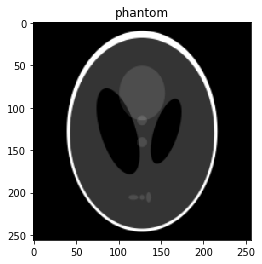

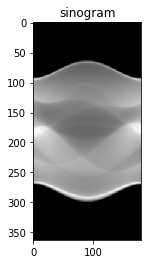

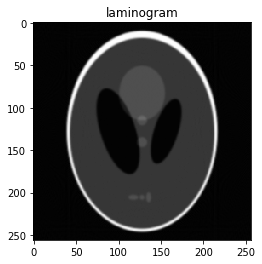

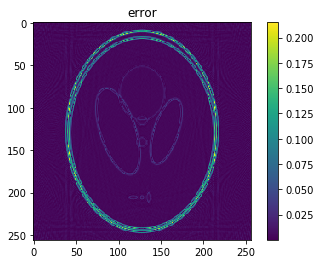

In [9]:
WHITE_LEVEL = 255
SIZE = 256
NUM_ANGLES = 180

phantom = cv2.imread('shepplogan.png', cv2.IMREAD_GRAYSCALE).astype(float) / WHITE_LEVEL
phantom = cv2.resize(phantom, (SIZE, SIZE))
plt.imshow(phantom, cmap ='gray')
plt.title('phantom')
plt.show()

angles = np.linspace(start=0, stop=179, num=NUM_ANGLES)
sinogram = skimage.transform.radon(phantom, angles)
plt.imshow(sinogram, cmap='gray')
plt.title('sinogram')
plt.show()

laminogram = skimage.transform.iradon(sinogram, angles, filter='shepp-logan') # "shepp-logan", "ramp"
plt.imshow(laminogram, cmap='gray')
plt.title('laminogram')
plt.show()

error = abs(phantom - laminogram)
plt.imshow(error)
plt.colorbar()
plt.title('error')
plt.show()

We can observe that all the low frequencies are reconstructed properly but not the high frequencies. Why?

In CT we are basically reconstructing from a radially undersampled 2D Fourier transform of an image, where the rate depends upon  the number of projections used. So if we don't sample finely enough, the frequencies that are closer to origin, i.e. the low-frequencies, get finely sampled, but the high-frequencies are sampled sparsely. Hence, we lose high-frequency content in the reconstructed image.

<img src="radial-sampling.png" width="360">


## Different Acquisition Geometries

- Fan-beam CT
- Cone-beam CT

<img src="fan-and-cone-beam.png" width="640">



## CT as an inverse problem

A second approach to CT image reconstruction defines the problem as a system
of linear equations. Each projection ray corresponds to a linear equation
that sums up the image pixels the ray passes through, i.e. computes the discrete
line integral, and demands it to be equal to the measured value.
$$
\mathbf{A} \mathbf{x} = \mathbf{p},
$$
where $\mathbf{x}$ is the object we are scanning/the ideal image and $\mathbf{p}$ are the projections that we obtain. $\mathbf{A}$ describes how each pixel contributed to a particular ray. In the simplest case, the elements of $\mathbf{A}$ will contain $1$ if the corresponding pixel contributed to a particular projection, or $0$ otherwise. 

<img src="pixel_proj_contrib.png" width="480">

This problem is heavily ill-posed because there can be many possible $\mathbf{x}$ that satisfy the above equation. The good news is that we can use our domain knowledge to induce priors on the reconstructed image. Commonly used priors are total variation, sparse priors, and recently convolutional neural networks.

Even for decently sized images, we cannot invert the matrix $\mathbf{A}$ in our life-time. Rather we choose to solve the following optimization problem:
$$
\arg\min_{\mathbf{x}}\left\Vert\mathbf{A}\mathbf{x}-\mathbf{p}\right\Vert_2^2.
$$
In the upcoming classes we will see that such problems are common in many image processing tasks, and we will discuss then how to solve such problems.

## Hough transform

Very similar in spirit to Radon transform is the Hough transform. 

We can consider each point of the source image and generate all possible $\left(\theta,s\right)$ combinations that represent lines passing through it.

Let's start by looking at the transform of a single point.

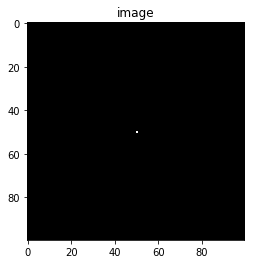

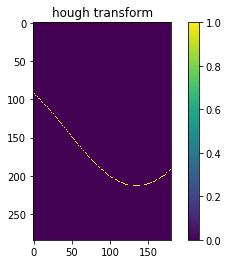

In [10]:
SIZE = 100

single_point = np.zeros((SIZE, SIZE))
middle = SIZE  // 2
single_point[middle, middle] = 1.0

ht_single_point = skimage.transform.hough_line(single_point)
plt.imshow(single_point, cmap='gray')
plt.title('image')
plt.show()

plt.imshow(ht_single_point[0])
plt.colorbar()
plt.title('hough transform')
plt.show()

Let's see what is the transform of a line.

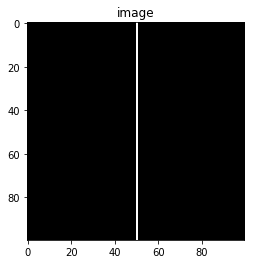

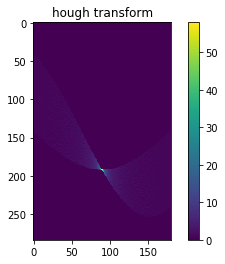

In [11]:
SIZE = 100

single_line =  np.zeros((SIZE, SIZE))
middle = SIZE // 2
single_line[:, middle] = 1.0

ht_single_line = skimage.transform.hough_line(single_line)
plt.imshow(single_line, cmap='gray')
plt.title('image')
plt.show()

plt.imshow(ht_single_line[0])
plt.title('hough transform')
plt.colorbar()
plt.show()

We can identify straight lines in the original image as intersections in the Hough transform.

Let's verify this with the following example.

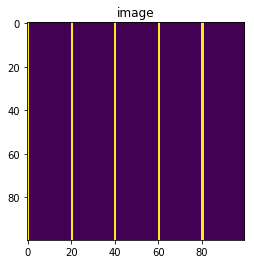

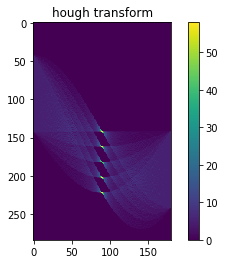

In [12]:
SIZE = 100
STEP = 20

parallel_lines =  np.zeros((SIZE, SIZE))
columns = range(0, SIZE, 20)
parallel_lines[:, columns] = 1.0

ht_parallel_lines = skimage.transform.hough_line(parallel_lines)
plt.imshow(parallel_lines)
plt.title('image')
plt.show()

plt.imshow(ht_parallel_lines[0])
plt.colorbar()
plt.title('hough transform')
plt.show()

Let's try a real image. We'll use an edge detection filter to only examine the edges.

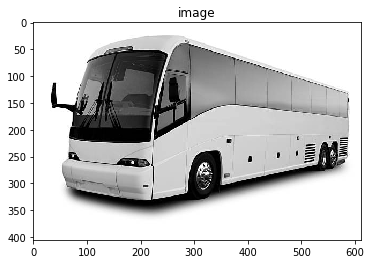

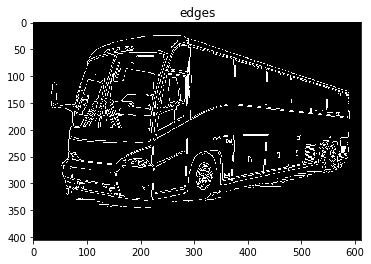

In [13]:
THERSHOLD1 = 50
THERSHOLD2 = 150
APERTURE_SIZE = 3

bus = cv2.imread('bus.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(bus, cmap='gray')
plt.title('image')
plt.show()

canny_bus = cv2.Canny(bus, THERSHOLD1, THERSHOLD2, apertureSize=APERTURE_SIZE)
plt.imshow(canny_bus, cmap='gray')
plt.title('edges')
plt.show()

Now we will use the Hough transform to identify the lines in the image.

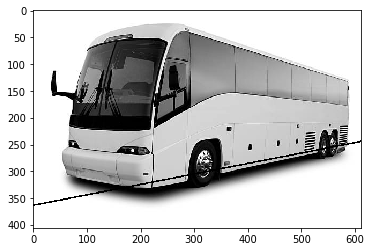

In [14]:
RHO = 1
THETA = np.pi / 180
THESHOLD = 200
COLOR = (0, 255, 255)
THICKNESS = 2

lines = cv2.HoughLines(canny_bus, RHO, THETA, THESHOLD)
for rho, theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 - 1000 * b)
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 + 1000 * b)
    y2 = int(y0 - 1000 * a)
    cv2.line(bus, (x1, y1), (x2, y2), COLOR, thickness=THICKNESS)

cv2.imwrite('hough-bus.jpg', bus)
plt.imshow(bus, cmap='gray')

As we can see, only a single line was recovered. This gives the impression that using the Hough transform as a feature extractor might work well in theory, but not in practice. Today convolutional neural networks are mostly used to identify features such as line.

The Hough transform can also be extended for detecting other shapes such as circles and ellipses. To do so, we just need to find a way to parameterize them accordingly.